## Projeto: Segmentação de mercado usando mineração de dados e clusterização

Segmentação de mercado é o processo de identificar, em um conjunto heterogêneo de consumidores, grupos com características e comportamentos semelhantes. É uma importante ferramenta para entender o mercado e direcionar ações específicas para cada tipo de cliente.
Existem várias metodologias para efetuar a segmentação. Uma muito conhecida é a (RFM), que visa dividir grupos de acordo com os seguintes critérios:
- <b>Recency</b>: quando a última compra foi efetuada;
- <b>Frequency</b>: com que frequência compras são efetuadas;
- <b>Monetary Value</b>: quanto o cliente costuma gastar.

Neste projeto, foram aplicadas técnicas de mineração de dados em <i>business intelligence</i> para um cliente varejista online do setor de presentes baseada no Reino Unido. O conjunto de dados utilizado refere-se a transações efetuadas entre 01/12/2010 e 09/12/2011.

O <b>meu objetivo</b> neste projeto é: extrair as principais características dos consumidores da loja e utilizar o modelo de clusterização <i>k-means</i> para separar esses consumidores em grupos com características semelhantes, facilitando assim a condução de ferramentas de marketing centrado no cliente de forma mais eficaz.

Fonte dos dados: <https://www.kaggle.com/datasets/carrie1/ecommerce-data>

### Carregando os Pacotes do Anaconda

In [1]:
# importando os principais módulos que usaremos ao longo do projeto

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import yellowbrick.cluster
import seaborn as sns
import pandas_profiling

import sklearn.cluster
from sklearn.cluster import KMeans
import sklearn.metrics
import sklearn.preprocessing

import missingno
import datetime
import copy

### Carregando dados

In [2]:
#Lendo os dados com a função .read_csv
df = pd.read_csv("C:/MyProjects/segmentacao_mercado_cluster/data.csv")

In [3]:
#Visualizando o dataFrame
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


Descrições das colunas, de acordo com o UCI Machine Learning Repository:

- <b>InvoiceNo</b>: Número da fatura. Nominal, um número integral de 6 dígitos atribuído exclusivamente a cada transação. Se este código começar com a letra 'c', isso indica um cancelamento.
- <b>StockCode</b>: código do produto (item). Nominal, um número integral de 5 dígitos atribuído exclusivamente a cada produto distinto.
- <b>Description</b>: Nome do produto (item). Nominal.
- <b>Quantity</b>: as quantidades de cada produto (item) por transação. Numérico.
- <b>InvoiceDate</b>: Data e hora do inventário. Numérico, o dia e a hora em que cada transação foi gerada.
- <b>UnitPrice</b>: preço unitário. Numérico, preço do produto por unidade em libras esterlinas.
- <b>CustomerID</b>: Número do cliente. Nominal, um número integral de 5 dígitos atribuído exclusivamente a cada cliente.
- <b>Contry</b>: nome do país. Nominal, o nome do país onde cada cliente reside.

In [4]:
#Analisando o tipo de cada variável do dataFrame
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [5]:
#Transformando da coluna 'InvoiceDate' para datetime 
df['InvoiceDate'] = df['InvoiceDate'].astype('datetime64[ns]')

### Pré-processamento dos dados

In [6]:
#Realizando uma exploração inicial do conjunto de dados utilizando a função .profile_report()
df.profile_report()

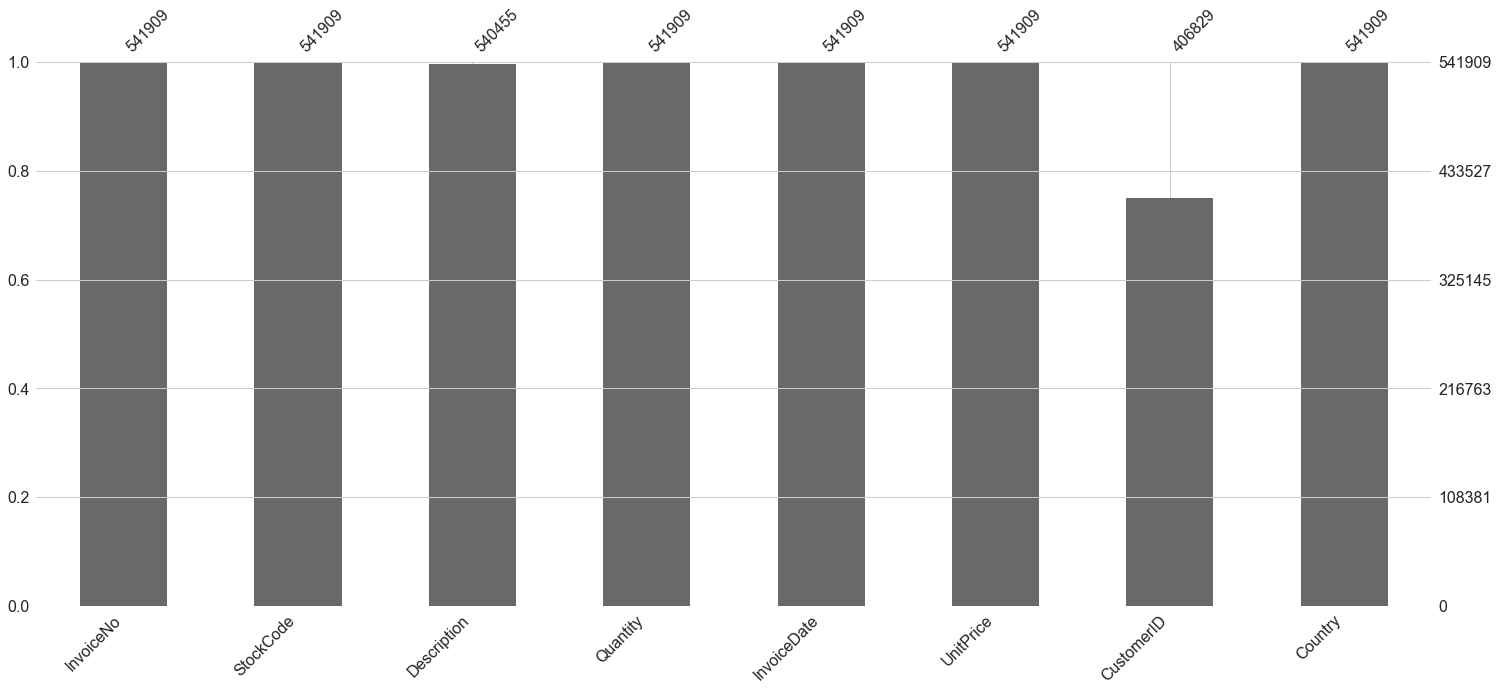

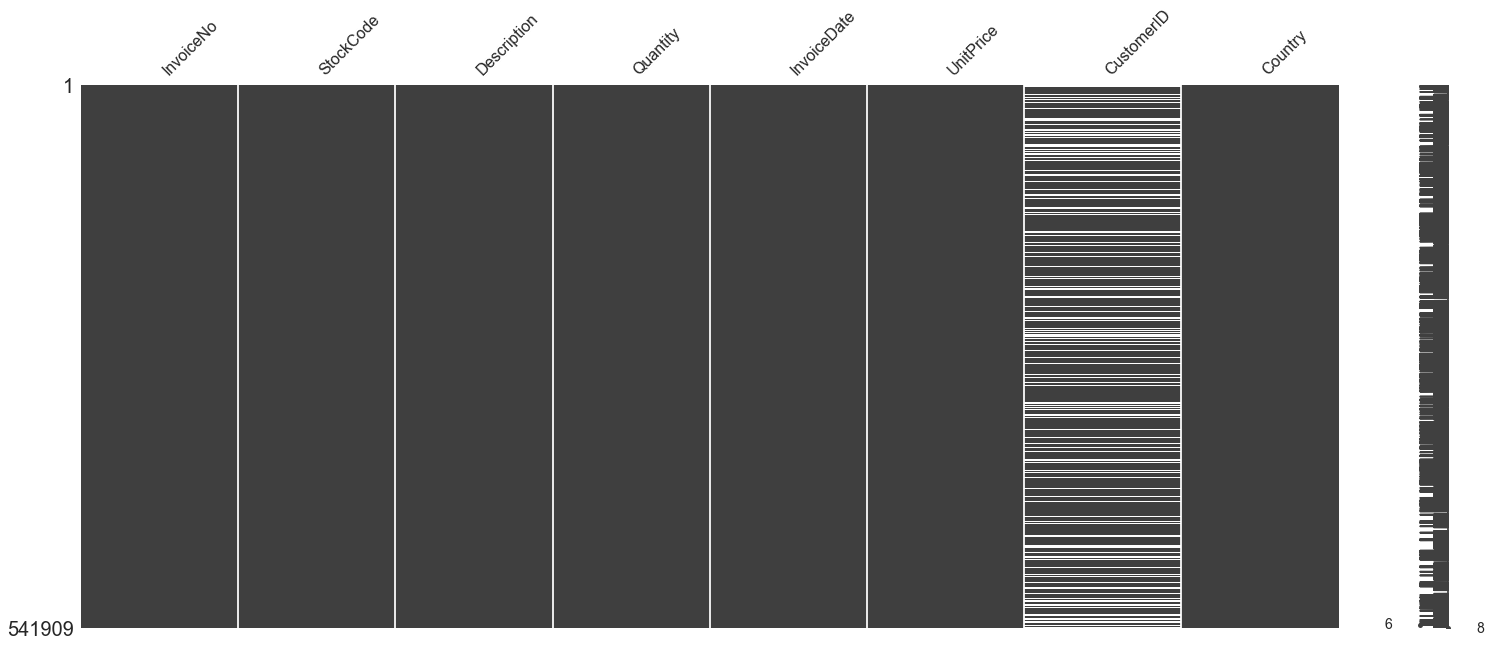

In [7]:
#Analisando o padrão de dados faltantes usando a função missingno
missingno.bar(df)
missingno.matrix(df);

Ao realizarmos a aplicação da função acima, percebe-se pelos gráficos gerados que existem dados faltantes na categoria CustomerID referente a identificação do cliente. Isso é explicado pelo fato de muitos compradores realizarem as compras sem se identificarem.

In [8]:
#Utilizando a função .dropna para remover as compras na qual existem dados faltantes dos compradores
df_new = df.dropna(axis = 0, subset = ['CustomerID'])

In [9]:
df_new

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [10]:
#Criando uma coluna do dataframe com o valor total de cada compra
df_new["SumTotal"] = df_new["Quantity"] * df_new["UnitPrice"]

In [11]:
#Criando agora, um data Frame apenas com Recência da última compra (contando em dias), 
#Frequência de compra e Valor Monetário (RFM)

snapshot_date = max(df_new.InvoiceDate) + datetime.timedelta(days=1)

df_raw = df_new.groupby(['CustomerID']).agg({
      'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
      'InvoiceNo': 'count',
      'SumTotal': 'sum'})

df_raw.rename(columns = {'InvoiceDate': 'Recência',
                            'InvoiceNo': 'Frequência',
                            'SumTotal': 'ValorMonetário'}, inplace=True)

Na célula acima foi utilizada a função timedelta, para calcular a diferenta entre duas datas. Essa conta facilita para calcularmos a quantos dias o cliente fez a sua última compra no site.

In [12]:
df_raw

,Recência,Frequência,ValorMonetário
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,13,176.60


Recência           1.249665
Frequência        18.153735
ValorMonetário    21.705287
dtype: float64


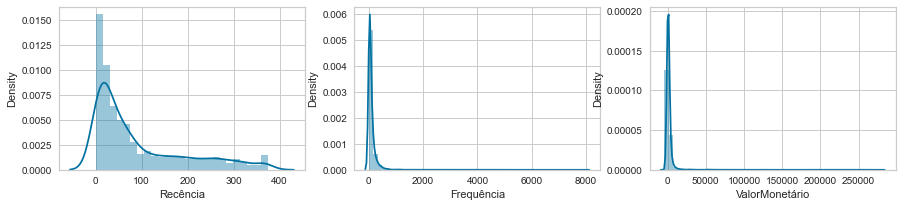

In [13]:
#Verificando a distribuição das variáveis do dataFrame se são assímétricas ou não, se não estiverem 
#assímetricas não podemos aplicar ainda o modelo de clusterização
print(df_raw.skew())

fig, ax = plt.subplots(1, 3, figsize=(15,3))

for i in range(3):
    sns.distplot(df_raw.iloc[:,i], ax=ax[i])

Os valores númericos apresentados acima, são relativos ao "skew" de cada variável. Este valor nos dá uma ideia do quanto as variáveis estão assímétricas. Quanto mais distante de 0, mais assímétrica é a distribuição. O que pode ser comprovado também de modo visual ao observarmos os gráficos de distribuição.
Essa alta distribuição atrapalha o modelo de clusterização, pois a classificação feita pelo modelo é baseado na distância de cada observação para o seu centróide , logo, quanto maior é essa assímetria dos dados, mais erros o modelo poderá cometer na classificação, o que pode prejudizar a sua eficiência e análise final do resultado.

Para resolver o problema da alta assímetria dos dados será aplicado a função powertransform do módulo sklearn..preprocessing. Essa função irá melhorar a distribuição dos dados através de uma tranformação matemática.

In [14]:
#Aplicação da função powertransform
arr_rfm = sklearn.preprocessing.power_transform(df_raw)

df_rfm = pd.DataFrame(arr_rfm,
                      index = df_raw.index,
                      columns = df_raw.columns)


Recência         -0.057833
Frequência       -0.000221
ValorMonetário    5.100041
dtype: float64


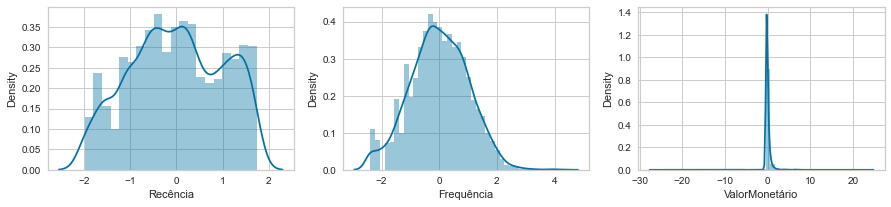

In [15]:
#Visualizando o resultado da transformação

print(df_rfm.skew())

fig, ax = plt.subplots(1, 3, figsize=(15,3))

for i in range(3):
    sns.distplot(df_rfm.iloc[:,i], ax=ax[i])

Perce-se uma melhora na distribuição dos dados a partir da aplicação da função powertransform. Ainda assim, a variável SumTotal possui um valor de skew bastante elevado. Podemos então aplicar uma segunda técnica que é a raiz cúbica apenas a essa variável do dataFrame.

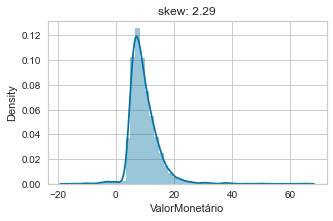

In [16]:
#Aplicando a raiz cúbica a coluna "ValorMonetário"
df_rfm['ValorMonetário'] = np.cbrt(df_raw['ValorMonetário'])

fig, ax = plt.subplots(figsize=(5,3))

sns.distplot(df_rfm.iloc[:,i],ax=ax)
plt.title(f'skew: {df_rfm.skew()[-1]:.3}');

Chegamos agora a um valor de skew de 2.29. Valor razoável e que agora nos permitir seguir para a modelagem dos dados com a aplicação do <i>k-means.

In [17]:
#Aplicando a normalização dos dados
df_rfm = (df_rfm-df_rfm.mean())/df_rfm.std()

### Modelagem dos dados

Primeiramente, precisamos definir o número de <i>clusters</i> ideal para o modelo <i>k-means</i>. Para isso irei utilizar o diagrama de silhueta. Este diagrama é construido com o cálculo do coeficiente de silhueta calculado para cada um dos <i>clusters</i>.
- Quanto mais próximo de 1 é o valor desse coeficiente, isso quer dizer que os dados estão mais próximos dos seus similares e afastados dos demais <i>clusters</i>.
- Quando este valor é mais próximo de 0, isso quer dizer que os valores estão mais próximo da fronteira entre <i>clusters</i>.
- Por último, quanto mais perto de -1 é este valor, sugere que as amostras estão em <i>clusters</i> errados.

O gráfico que mostra o diagrama de silhueta, é criado através da biblioteca <i>Yellowbrick</i>, que contém rotinas para visualização de resultados de aprendizado de máquina. Em particular, utilizaremos o método <i>silhouette_visualizer</i> do módulo <i>yellowbrick.cluster</i>, que aceita um modelo e uma matriz de dados e plota o diagrama de silhueta.

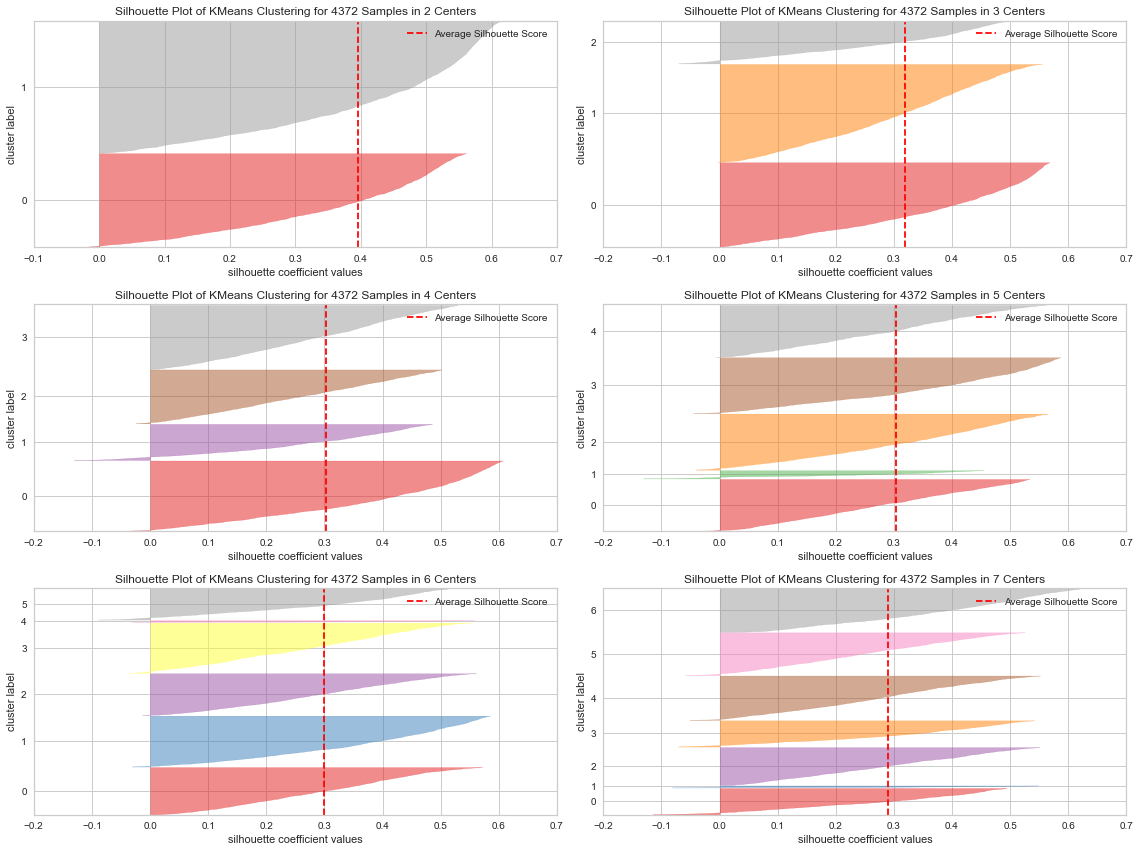

In [18]:
#Definição da função para criação do diagrama de silhueta
def plot_silhueta(X, k_list):
        
    n_lines = int(np.ceil(len(k_list)/2))    
    
    fig, ax = plt.subplots(n_lines, 2, figsize = (16,4*n_lines))

    for i in range(len(k_list)):

        m = sklearn.cluster.KMeans(k_list[i])
        yellowbrick.cluster.silhouette_visualizer(m, X, show=False, ax=ax.ravel()[i]);

    fig.tight_layout()
    return
plot_silhueta(df_rfm, [2,3,4,5,6,7])

O esperado, a partir da observação dos gráficos acima é que cada <i>cluster</i> atinja pelo menos valor acima do coef. de silhueta médio (representado pela linha tracejada nos gráficos). Podemos observar então, que a divisão dos <i>clusters</i>, representados na imagem possuem uma boa silhueta em todas as divisões de <i>clusters</i>, sendo os valore de coeficiente de silhueta acima da média. Para escolhermos então um valor de <i>k</i> iremos levar em consideração a semelhança do tamanhos dos <i>clusters</i>. Nesse caso, os conjuntos de dados se parecem mais semelhantes em seu tamanho quando <i>k</i> = 4.

Podemos fazer uma comparação da divisão dos dados plotando um gráfico 3d do RFM para <i>k</i> = 3 e <i>k</i> = 4. 

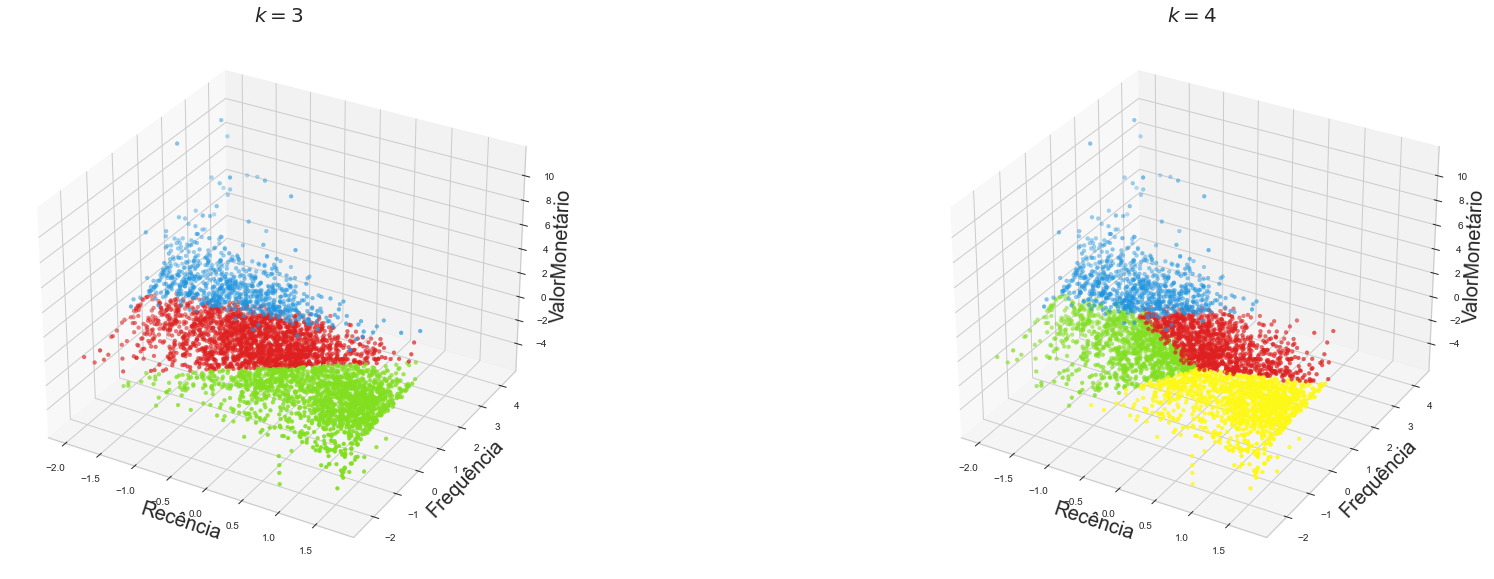

In [19]:
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(1,2, subplot_kw = {'projection':'3d'}, figsize=(30,10))

k = [3,4]
for i in range(len(k)):
             
    kmeans = sklearn.cluster.KMeans(n_clusters= k[i], random_state=0)
    colors = ['#DF2020', '#81DF20', '#2095DF', '#FFF917']
    df_rfm['cluster'] = kmeans.fit_predict(df_rfm[['Recência', 'Frequência', 'ValorMonetário']])
    df_rfm['c'] = df_rfm.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3]})

#ax[i] = fig.add_subplot(131, projection='3d')
    ax[i].set_title(f'$k={k[i]}$', size=20)               
    ax[i].scatter(df_rfm.Recência, df_rfm.Frequência, df_rfm.ValorMonetário, c=df_rfm.c, cmap='viridis', s=15)
    ax[i].set_xlabel('Recência', size = 20)
    ax[i].set_ylabel('Frequência', size = 20)
    ax[i].set_zlabel('ValorMonetário', size = 20)

Com o plot do gráfico em 3D, a visualização da divisão dos <i>clusters</i> fica mais clara. Nesses gráficos, cada conjunto de dados agrupados (<i>clusters</i>), são representados de uma cor. Percebe-se que os clientes representados pelos dados distribuidos na cor vermelha no gráfico da esquerda (k =3), são divididos em dois grupos quando colocamos o número de <i>clusters igual a 4.

Para extrair mais informações sobre <i>clusters</i> formados pelo modelo, vale a pena, utilizarmos o <i>snake plot</i> baseado no RFM e através do gráfico verificamos os grupos de clientes mais valiosos para o negócio e o qual a empresa deve investir mais em estratégicas de <i>marketing</i>.

In [20]:
# Função para separa os conjuntos para vários valores de k
del df_rfm['c']
def k_means_for_k (X, k_list, ax = None):
    
    kmeans_per_k = [sklearn.cluster.KMeans(n_clusters=k, random_state=0).fit(X)
                    for k in k_list]
    
    return kmeans_per_k

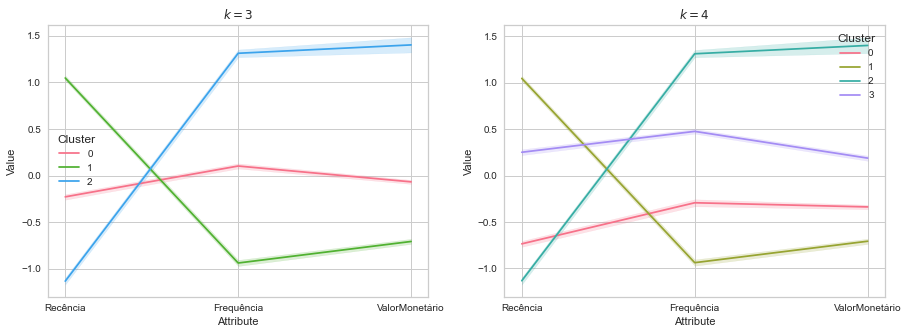

In [21]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
kmeans_ = k_means_for_k(df_rfm, range(1,11), ax=ax[0])
k = [2,3]

for i in range(len(k)):
    
    df_tmp = copy.deepcopy(df_rfm)
    df_tmp['ID'] = df_rfm.index
    df_tmp['Cluster'] = kmeans_[k[i]].labels_
    df_tmp_melt = pd.melt(df_tmp.reset_index(),
                          id_vars=['ID', 'Cluster'],
                          value_vars=['Recência','Frequência','ValorMonetário'],
                          var_name='Attribute',
                          value_name='Value')

    sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_tmp_melt, 
                 ax=ax[i], palette = sns.color_palette("husl", k[i]+1))
    
    ax[i].set_title(f'$k={k[i]+1}$')

Os sombreados das retas mostram os intervalos de confiança de 95%.

Do primeiro gráfico acima (em que  k=3 ), percebe-se que os clusters representam três tipos distintos de clientes:

- <b>0</b> :  compraram há não muito tempo, aparecem com média frequência e não gastam muito.
- <b>1</b>  : compraram há muito tempo, aparecem com baixa frequência e gastam pouco. Em tese, é o cluster de clientes que agregam menos valor ao negócio. Talvez com uma estratégia de marketing melhor para atingir esses cleinte, é possível aumentat r a sua recência e baixa frequência e com a distribuição de cupons de desconto eles possam consumir mais.
- <b>2</b>  : compraram há pouco tempo, aparecem com bastante frequência e gastam muito. Em tese, é o cluster de clientes mais valiosos e que precisam ser cuidados para que continuem com esse comportamento.

A introdução de mais um cluster no modelo divide o cluster 0 do gráfico da esquerda em dois, os clusters 0 e 3 no gráfico da direita. A escolha por efetuar ou não essa divisão adicional pode ser uma decisão estratégica da companhia, baseada nas ações que serão tomadas a partir da informação fornecida pelo modelo.